In [49]:
import pandas as pd
import numpy as np

import requests

from dotenv import load_dotenv
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import fastcore.all as fc

from ta import add_all_ta_features
from ta.utils import dropna

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from pyts.image import GramianAngularField

# data util functions
from data import get_data, p2df, zscore_normalize, minmax_normalize, normalize_, create_window

In [50]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [51]:
# FOR THIS WE WILL USE THE POLYGON API
load_dotenv()
POLYGON_API_KEY = os.getenv('POLYGON_API_KEY')

In [402]:
# # load some data, we will use TSLA
data = get_data(POLYGON_API_KEY, ticker="SPY", multiplier=15, timespan="minute", from_="2022-01-09", to="2023-02-10", limit=50000)

In [403]:
# turn our data into a dataframe
df = p2df(data, convert_timestamp=True) # convert timestamp to datetime

# for our GADF we will first add a lot of TA features
# the only features we are interested in are open, high, low, close, volume so lets clear the rest
df = df[['open', 'high', 'low', 'close', 'volume']]
df.head()

# lets drop any na values, there shouldnt be any with polgyon data
df = dropna(df)

# lets now add all the ta features
df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

df

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,466.50,466.50,465.85,466.180,9535.0,1.466923e+02,9535.0,0.015385,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,466.180000,5.251643,0.000000,0.000000
1,466.24,466.68,466.24,466.680,5773.0,5.919692e+03,15308.0,0.386706,2886.500000,2172.180842,...,0.008555,0.001711,0.006844,-3.242132,-0.648426,-2.593706,466.355613,0.107255,0.107197,0.107255
2,466.74,466.86,466.55,466.550,2699.0,3.220692e+03,12609.0,0.178858,2424.018571,2814.005187,...,0.012936,0.003956,0.008980,-8.859424,-2.290626,-6.568798,466.422981,-0.027856,-0.027860,0.079368
3,466.75,466.76,466.22,466.220,2741.0,4.796923e+02,9868.0,0.023120,1948.511633,-4235.680409,...,0.010574,0.005280,0.005295,-13.677094,-4.567920,-9.109174,466.356394,-0.070732,-0.070757,0.008580
4,466.00,466.79,465.95,466.790,3899.0,4.378692e+03,13767.0,0.177656,1987.642828,-2585.278276,...,0.018355,0.007895,0.010460,-16.461779,-6.946691,-9.515087,466.522506,0.122260,0.122185,0.130851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679,450.39,451.15,450.11,450.350,2246884.0,1.199736e+08,45854912.0,-0.242549,-743999.139698,-19.671688,...,-0.181344,-0.130052,-0.051292,27.419627,18.510791,8.908836,451.805190,-0.015541,-0.015542,-3.395684
3680,450.33,450.39,449.68,450.110,1688907.0,1.203305e+08,44166005.0,-0.213715,-695618.931170,-25.013219,...,-0.197465,-0.143535,-0.053931,23.737851,19.556203,4.181648,451.598953,-0.053292,-0.053306,-3.447166
3681,450.10,450.51,449.67,450.430,1379007.0,1.214468e+08,45545012.0,-0.167082,-533204.478146,3.350237,...,-0.202212,-0.155270,-0.046942,19.308965,19.506755,-0.197790,451.507479,0.071094,0.071068,-3.378523
3682,450.43,450.44,449.35,450.240,1571790.0,1.224418e+08,43973222.0,-0.128315,-499695.281268,-13.522799,...,-0.206995,-0.165615,-0.041380,16.429276,18.891259,-2.461983,451.336062,-0.042182,-0.042191,-3.419280


In [404]:
# creating windows 1 month with 1d intervals
window_size = 2
target = df['close'].rolling(window_size).apply(lambda x: (x[-1] - x[0]) / x[0], raw=True).values

In [405]:
pd.Series(target).describe()

count    3683.000000
mean       -0.000008
std         0.001860
min        -0.013936
25%        -0.000719
50%         0.000000
75%         0.000744
max         0.012708
dtype: float64

In [406]:
# lets scale our data, not including our target
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df.values)
data_normalized = scaler.transform(df.values)

# scaler = StandardScaler()
# scaler = scaler.fit(df.values)
# data_normalized = scaler.transform(df.values)

In [407]:
class Data:
    def __init__(self, data, target): self.data, self.target = data, target
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.target[i]

In [408]:
data = Data(data_normalized, target)

In [409]:
def create_window(data, start=0, size=28, predictive_time=1):
    """Create a window of data"""
    x = data.data[start:start+size]
    y = data.target[start:start+size+predictive_time]
    return {'data': x, 'target': y[-1]}

In [411]:
time_window = 4*6
window = create_window(data, start=1, size=time_window, predictive_time=4)
# create window sliding with stride of 1
windows = [create_window(data, start=i, size=time_window) for i in range(len(data)-time_window)]
len(windows)

3660

In [412]:
# create a split of windows to train and test
train_split = int(len(windows) * 0.8)
train_windows = windows[:train_split]
test_windows = windows[train_split:]

In [413]:
gadf = GramianAngularField(image_size=28, method='difference')

In [414]:
# lets create our CNN dataset class
class CNNDataset(Dataset):
    def __init__(self, windows, transform_fn=gadf, conv3d=False):
        self.conv3d = conv3d
        self.X = [transform_fn.fit_transform(window['data']) for window in windows]
        self.y = [window['target'] for window in windows]

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float)
        # reshape for conv3
        if self.conv3d: x = x[None, :, :, :]
        y = torch.tensor(self.y[idx], dtype=torch.float).unsqueeze(0)
        return x, y

In [415]:
from dataclasses import dataclass

In [416]:
@dataclass
class Dls:
    train: DataLoader
    valid: DataLoader

In [417]:
conv3d = True

train_ds = CNNDataset(train_windows, conv3d=conv3d, transform_fn=gadf)
valid_ds = CNNDataset(test_windows, conv3d=conv3d, transform_fn=gadf)

# create our dataloaders
dls = Dls(
    train = DataLoader(train_ds, batch_size=32, shuffle=True),
    valid = DataLoader(valid_ds, batch_size=32, shuffle=True))

xb, yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([32, 1, 24, 28, 28]), torch.Size([32, 1]))

In [418]:
def_device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
def_device = 'cpu' if conv3d else def_device

def to_device(data, device=def_device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)): return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [419]:
class Learner:
    """This is our main class that will be responsible to experimenting and training various models. It serves the purpose of being a vehicle to experiment quickly"""
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        """
        model: <PyTorch Model> the model we are going to train
        dls: <Pytorch DataLoader> the dataloaders we are going to use
        loss_func: <Callable> the loss function we are going to use
        lr: <float> the learning rate we are going to use
        opt_func: <PyTorch optimizer (can be custom)> the optimizer we are going to use
        """
        fc.store_attr() # easy method to store all attributes, prevents mistakes

    def one_batch(self):
        """This method is responsible for one batch of training/evaluation"""
        self.xb, self.yb = to_device(self.batch) # move batch to device
        self.preds = self.model(self.xb) # get predictions
        self.loss = self.loss_func(self.preds, self.yb) # calculate loss
        if self.model.training:
            self.loss.backward() # calculate gradients
            self.opt.step() # update weights
            self.opt.zero_grad() # zero gradients
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        """This method is responsible for calculating statistics"""
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.model.training = train # set model to training mode or evaluation mode
        dl = self.dls.train if train else self.dls.valid # get the correct dataloader
        for self.num, self.batch in enumerate(dl): 
            self.one_batch() # call one_batch method, self.batch will be set to the current batch
        n = sum(self.ns)
        print(f"Epoch: {self.epoch+1}", 'train' if self.model.training else 'valid', f"Loss: {sum(self.losses).item()/n}")
    
    def fit(self, n_epochs):
        """Very lightweight fit method, this is the highest level to train a model via the Learner object"""
        self.losses, self.ns = [], []
        self.model.to(def_device) # place model on appropriate device TODO: Allow this to be changed via fit calls if necessary
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr) # create optimizer
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True) # training
            self.one_epoch(False) # evaluation

In [420]:
def conv(ni, nf, ks=3, stride=2, act=True, act_fn=nn.ReLU):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, act_fn())
    return res

In [421]:
class SimpleCNN2D(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super().__init__()
        batch_size, channels, height, width = input_shape
        self.conv_layers = nn.Sequential(
            conv(channels, 16, act_fn=activation),
            conv(16, 32, act_fn=activation),
            conv(32, 64, act_fn=activation),
            conv(64, 64, act_fn=activation),
            conv(64, 1, act=False),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x
    
class SimpleCNN3D(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(SimpleCNN3D, self).__init__()
        batch_size, channels, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 64),
            activation(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
class TinyCNN(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(TinyCNN, self).__init__()
        _, _, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        self.conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_output_size, 16),
            activation(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
class DeepCNN(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(DeepCNN, self).__init__()
        _, _, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        self.conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_output_size, 128),
            activation(),
            nn.Linear(128, 64),
            activation(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

class TinyTransformer(nn.Module):
    def __init__(self, input_shape, nhead=8, num_layers=6, dropout=0.1):
        super(TinyTransformer, self).__init__()
        _, _, depth, height, width = input_shape
        self.embed_dim = depth * height * width
        self.pos_encoder = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(),
        )
        encoder_layers = TransformerEncoderLayer(d_model=self.embed_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.Linear(self.embed_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = x.view(-1, self.embed_dim)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.head(x)
        return x

In [422]:
# # create a simple 2d cnn
# simple_cnn = SimpleCNN2D(xb.shape)
# create a simple 3d cnn
simple_cnn = SimpleCNN3D(xb.shape, activation=nn.GELU)
# simple_cnn = TinyTransformer(xb.shape, nhead=2, num_layers=1, dropout=0.1)

# number of parameters/
print(f"Number of parameters: {sum(p.numel() for p in simple_cnn.parameters())}")

Number of parameters: 616545


In [423]:
# # Freeze conv_layers
# for param in simple_cnn.conv_layers.parameters():
#     param.requires_grad = False

# # replace the head with a new one
# simple_cnn.head = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(simple_cnn.conv_output_size, 32),
#             nn.GELU(),
#             nn.Linear(32, 1)
#         )

In [424]:
learn = Learner(simple_cnn, dls, loss_func=nn.MSELoss(), lr=0.01, opt_func=optim.RAdam)

In [425]:
learn.fit(30)

Epoch: 1 train Loss: 0.0041141552351863005
Epoch: 1 valid Loss: 0.003293504871305872
Epoch: 2 train Loss: 0.0018341648412170594
Epoch: 2 valid Loss: 0.0016511948382268186
Epoch: 3 train Loss: 0.0011811909686765291
Epoch: 3 valid Loss: 0.0011026836700995329
Epoch: 4 train Loss: 0.0008715748066939189
Epoch: 4 valid Loss: 0.00082813169135422
Epoch: 5 train Loss: 0.0006909870927668225
Epoch: 5 valid Loss: 0.0006634686683696476
Epoch: 6 train Loss: 0.0005726264384319851
Epoch: 6 valid Loss: 0.0005536344750548539
Epoch: 7 train Loss: 0.0004891026866891997
Epoch: 7 valid Loss: 0.0004752141251217844
Epoch: 8 train Loss: 0.00042698178552555676
Epoch: 8 valid Loss: 0.0004163633930227144
Epoch: 9 train Loss: 0.00037898720643204123
Epoch: 9 valid Loss: 0.00037071109903749004
Epoch: 10 train Loss: 0.0003408486991738534
Epoch: 10 valid Loss: 0.00033409126469346345
Epoch: 11 train Loss: 0.000309694636039371
Epoch: 11 valid Loss: 0.0003041603289252185
Epoch: 12 train Loss: 0.0002840441046373219
Epoch:

In [426]:
# let's run some predictions, we will plot the predictions and the actual values
def plot_preds(preds, yb):
    plt.plot(preds, label="preds")
    plt.plot(yb, label="actual")
    plt.legend()

def predict_plot(xb, yb, model):
    # move to device
    xb, yb = to_device(xb), to_device(yb)
    if isinstance(model, nn.Module): model = to_device(model)

    # get predictions
    preds = model(xb)

    # plot predictions
    with torch.no_grad(): plot_preds(preds.squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

import numpy as np

def plot_preds(preds, yb):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(preds, label="preds")
    ax.plot(yb, label="actual")
    turning_points = np.where(np.diff(np.sign(preds)))[0]
    ax.plot(turning_points, preds[turning_points], 'ro', label="pred pivots")

    turning_points = np.where(np.diff(np.sign(yb)))[0]
    ax.plot(turning_points, yb[turning_points], 'bo', label="actual pivots")
    ax.legend()

    for x in turning_points:
        ax.axvline(x=x, color='black', linestyle='--')

def predict_plot(xb, yb, model):
    # move to device
    xb, yb = to_device(xb), to_device(yb)
    if isinstance(model, nn.Module): model = to_device(model)

    # get predictions
    preds = model(xb)

    # plot predictions
    with torch.no_grad(): plot_preds(preds.squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

def calculate_correct_pivots(preds, yb):
    preds_turning_points = np.where(np.diff(np.sign(preds)))[0]
    yb_turning_points = np.where(np.diff(np.sign(yb)))[0]
    
    common_turning_points = set(preds_turning_points).intersection(set(yb_turning_points))
    if len(common_turning_points) == 0:
        return 0.0
    
    num_correct = 0
    for tp in common_turning_points:
        if np.sign(preds[tp] - preds[tp-1]) == np.sign(yb[tp] - yb[tp-1]):
            num_correct += 1
    
    return float(num_correct) / len(common_turning_points)



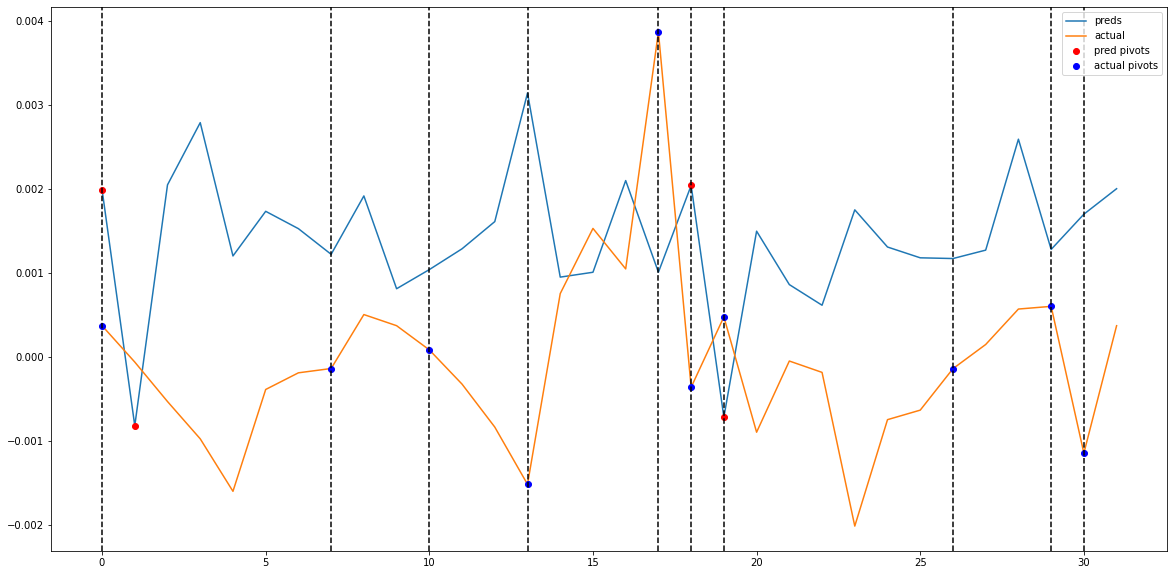

In [427]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

In [428]:
calculate_correct_pivots(simple_cnn(xb).squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

0.0

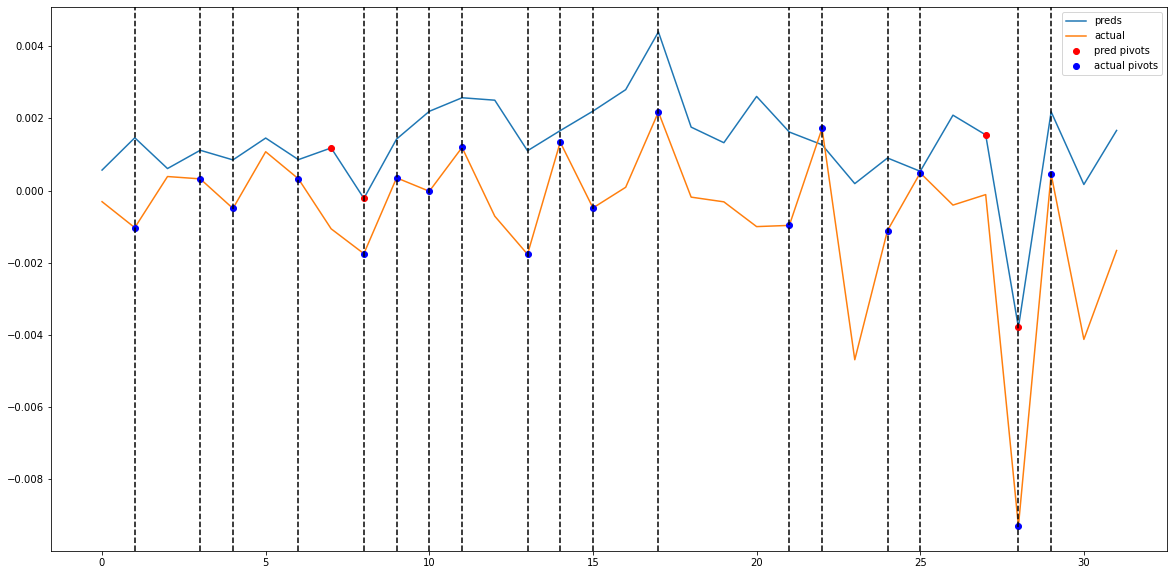

In [429]:
# plot predictions
xb, yb = next(iter(dls.train))
predict_plot(xb, yb, simple_cnn)

In [305]:
calculate_correct_pivots(simple_cnn(xb).squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

1.0